## Split Dataset and Upload into S3 Bucket

In this file we split the dataset into training, validation, and testing. Then we upload the three sub-datasets into three separate folders in AWS S3 bucket.

We will only use a reduced number of images:
- Training 20000 images
- Validation 5000 images
- Test 5000 Images

Here is a folder structure in S3 bucket:
 - training_imgs
   - images from 1 to 162770
 - validation_imgs:
   - images from 162771 to 182637
 - testing_imgs:
   - images from 182638 to 202599
 - user_imgs:
   - images uploaded by user from web app

In [1]:
# train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train')
# validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')
# s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_sdk')
# print(train_data)

In [9]:
# import libraries
import pandas as pd
import numpy as np
import cv2, boto3   
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

In [10]:
TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [11]:
# Read in attribute dataset
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0

In [12]:
df_partition = pd.read_csv('list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [13]:
df_partition['partition'].value_counts()

0    162770
2     19962
1     19867
Name: partition, dtype: int64

#### Merge the partition values into attribute data frame.

In [14]:
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


## Data Augmentation (modifying images):
Data Augmentation allows to generate images with modifications to the original ones. The following code is just a illustration using example photo. We will do augmentation to the training dataset later.

In [8]:
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

In [18]:
images_folder = 'img_align_celeba/img_align_celeba/'
EXAMPLE_PIC = images_folder + '007324.jpg'

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

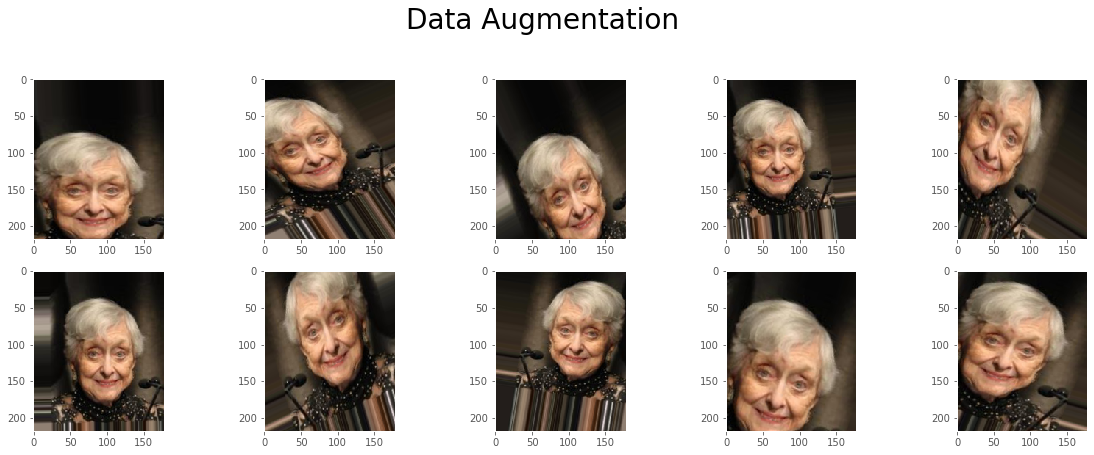

In [9]:
# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()


## Split dataset
Split to three sets:

In [15]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

In [16]:
def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])
    
    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

In [ ]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=BATCH_SIZE,
)

In [ ]:
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(x_valid, y_valid,)

In [ ]:
# upload all images to S3
def upload_imgs():
    key = "{}/{}/examples".format(prefix,data_partition_name)
    url = 's3://{}/{}'.format(bucket, key)

    boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
    print('Done writing to {}'.format(url))